<a href="https://colab.research.google.com/github/prabdeepkaur/algo_strategies_mini_project2_prabdeep/blob/main/CAPSTONE_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this in Colab (networkx may already be installed)
!pip install -q networkx

import itertools
import math
import time
import heapq
import functools
import random
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Notebook-wide plotting style
plt.rcParams.update({'figure.max_open_warning': 0, 'axes.titlesize': 12, 'axes.labelsize': 11})


In [2]:
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

# Map index -> name and name -> index
idx = {name:i for i, name in enumerate(locations)}
name = {i:name for name,i in idx.items()}

# Parcels: value, time-window (earliest, latest), weight
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30
START_TIME = 8.0   # vehicle leaves warehouse at 8:00
SERVICE_TIME = 0.5 # 30 minutes service at each stop


In [3]:
n = len(locations)

# adjacency list for weighted undirected graph (assignment distances symmetrical)
graph = {locations[i]: {} for i in range(n)}
for i in range(n):
    for j in range(n):
        if i != j and distance_matrix[i][j] > 0:
            graph[locations[i]][locations[j]] = distance_matrix[i][j]

def dijkstra_from(start):
    dist = {node: math.inf for node in graph}
    parent = {node: None for node in graph}
    dist[start] = 0
    pq = [(0, start)]
    while pq:
        d,u = heapq.heappop(pq)
        if d>dist[u]: continue
        for v,w in graph[u].items():
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                parent[v] = u
                heapq.heappush(pq, (nd, v))
    return dist, parent

# Precompute all-pairs shortest distances and parents (small graph so ok)
all_pairs_dist = {}
all_pairs_parent = {}
for u in graph:
    d,p = dijkstra_from(u)
    all_pairs_dist[u] = d
    all_pairs_parent[u] = p

def reconstruct_path(u, v):
    # Reconstruct shortest path from u to v using parent map of u
    parent = all_pairs_parent[u]
    if u == v: return [u]
    if parent[v] is None:
        return None
    path = []
    cur = v
    while cur is not None:
        path.append(cur)
        if cur==u: break
        cur = parent[cur]
    if path[-1] != u:
        return None
    return list(reversed(path))



In [4]:
# A recursive function that returns minimal remaining distance from current node
@functools.lru_cache(None)
def delivery_cost_rec(current_idx, visited_mask):
    """
    current_idx : index of current location (0 for Warehouse)
    visited_mask : bitmask for customer nodes visited (bits 1..n-1)
    returns: minimal remaining travel distance to visit all remaining chosen nodes and return to base
    """
    # If all customers visited -> return cost to go back to warehouse (if not at warehouse)
    all_mask = (1 << n) - 1
    if visited_mask == all_mask:
        return 0 if current_idx == 0 else distance_matrix[current_idx][0]
    best = math.inf
    for nxt in range(1, n):  # customers are 1..n-1
        if not (visited_mask & (1<<nxt)):
            cur_node = locations[current_idx]
            nxt_node = locations[nxt]
            # prefer shortest-path distance between nodes (here we have direct matrix)
            travel = distance_matrix[current_idx][nxt]
            cost = travel + delivery_cost_rec(nxt, visited_mask | (1<<nxt))
            best = min(best, cost)
    return best

# Example usage for full set (starting at Warehouse, visited mask includes only 0)
start_mask = 1 << 0
min_est = delivery_cost_rec(0, start_mask)
print("Recurrence-based minimal travel estimate (starting at Warehouse, visit all):", min_est)


Recurrence-based minimal travel estimate (starting at Warehouse, visit all): 18


In [6]:

# Greedy: choose parcels with highest value/weight until capacity
items = []
for loc, info in parcels.items():
    items.append((loc, info['value'], info['weight'], info['time']))

def greedy_knapsack(items, capacity):
    # items: list of (loc, value, weight, time)
    items_sorted = sorted(items, key=lambda x: x[1]/x[2], reverse=True)
    chosen = []
    rem = capacity
    for it in items_sorted:
        if it[2] <= rem:
            chosen.append(it)
            rem -= it[2]
    return chosen

greedy_selection = greedy_knapsack(items, vehicle_capacity)
print("Greedy knapsack selection:", greedy_selection)

# DP for time-windows: bitmask DP to find feasible order visiting a given subset
def time_window_feasible_order(subset_locs):
    """
    subset_locs: list of location names (e.g., ['C1','C3'])
    Returns: (feasible, best_order, arrival_times) or (False, None, None)
    We use DP over permutations with pruning using time windows and shortest distances.
    """
    m = len(subset_locs)
    indices = [idx[loc] for loc in subset_locs]
    # Map from local index to global index
    # We'll do bitmask DP where state is (mask, last_idx_global), storing earliest arrival time possible at that state.
    start_mask = 0
    full_mask = (1<<m) - 1
    # Map local pos in subset to bit position 0..m-1
    loc_to_bit = {indices[i]: i for i in range(m)}
    # DP table: dict[(mask, last_global)] = earliest finish time (after service)
    from collections import defaultdict
    dp = {}
    parent = {}
    # initialize transitions from Warehouse to each chosen location if feasible w.r.t time window
    for i, g in enumerate(indices):
        loc_name = locations[g]
        earliest, latest = parcels[loc_name]['time']
        travel = all_pairs_dist['Warehouse'][loc_name]  # travel time from warehouse
        arrival = START_TIME + travel
        if arrival <= latest:
            start_service = max(arrival, earliest)
            finish = start_service + SERVICE_TIME
            mask = 1 << i
            dp[(mask, g)] = finish
            parent[(mask, g)] = (None, None)  # from start
    # DP over masks
    for mask in range(1, full_mask+1):
        for last_local in range(m):
            last_global = indices[last_local]
            key = (mask, last_global)
            if key not in dp: continue
            cur_finish = dp[key]
            if mask == full_mask:
                continue
            # try add another node not in mask
            for j_local in range(m):
                if mask & (1<<j_local): continue
                j_global = indices[j_local]
                loc_name = locations[j_global]
                earliest, latest = parcels[loc_name]['time']
                travel = all_pairs_dist[locations[last_global]][loc_name]
                arrival = cur_finish + travel
                if arrival <= latest:
                    start_service = max(arrival, earliest)
                    finish = start_service + SERVICE_TIME
                    new_mask = mask | (1<<j_local)
                    key2 = (new_mask, j_global)
                    if key2 not in dp or finish < dp[key2]:
                        dp[key2] = finish
                        parent[key2] = (key, last_global)
    # check if any full_mask entry exists
    feasible_entries = [(k,v) for (k,v) in dp.items() if k[0]==full_mask]
    if not feasible_entries:
        return False, None, None
    # choose the one with earliest finish
    best_key = min(feasible_entries, key=lambda x: x[1])[0]
    # reconstruct order
    order = []
    cur = best_key
    while cur and parent[cur][0] is not None:
        prev, _ = parent[cur]
        order.append(locations[cur[1]])
        cur = prev
    # final append first one
    order.append(locations[cur[1]])
    order = list(reversed(order))
    # compute arrival times for the order
    times = []
    t = START_TIME
    prev = 'Warehouse'
    for loc in order:
        travel = all_pairs_dist[prev][loc]
        arrival = t + travel
        start_service = max(arrival, parcels[loc]['time'][0])
        times.append((loc, arrival, start_service))
        t = start_service + SERVICE_TIME
        prev = loc
    return True, order, times

# Test time-window DP for greedy selection
chosen_locs = [g[0] for g in greedy_selection]
feasible, order, times = time_window_feasible_order(chosen_locs)
print("Greedy chosen locs:", chosen_locs)
print("Time-window feasible?", feasible)
if feasible:
    print("Order:", order)

    print("Times (arrival, start_service):", times)


Greedy knapsack selection: [('C1', 50, 10, (9, 12)), ('C2', 60, 20, (10, 13))]
Greedy chosen locs: ['C1', 'C2']
Time-window feasible? False


MST edges (node indices): [(1, 0, 4), (2, 1, 5), (3, 2, 3)]


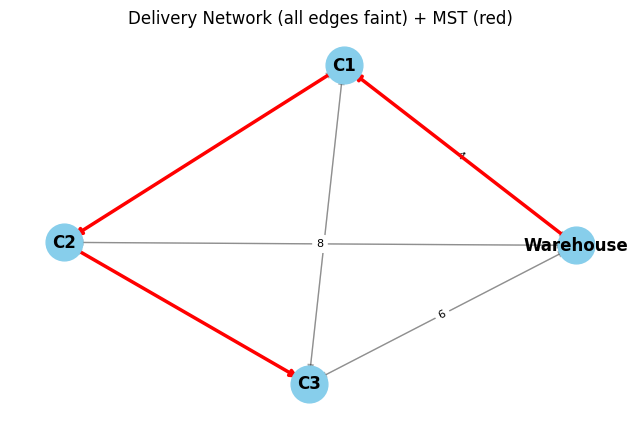

In [7]:
def prim_mst(adj_matrix):
    # Simple Prim's algorithm on dense matrix
    N = len(adj_matrix)
    in_mst = [False]*N
    key = [math.inf]*N
    parent = [-1]*N
    key[0] = 0
    for _ in range(N):
        u = min((key[i], i) for i in range(N) if not in_mst[i])[1]
        in_mst[u] = True
        for v in range(N):
            w = adj_matrix[u][v]
            if w>0 and not in_mst[v] and w < key[v]:
                key[v] = w
                parent[v] = u
    edges = []
    for v in range(1, N):
        edges.append((v, parent[v], adj_matrix[v][parent[v]]))
    return edges

mst_edges = prim_mst(distance_matrix)
print("MST edges (node indices):", mst_edges)
# Build networkx graph for beautiful plotting
G = nx.DiGraph()
for i, u in enumerate(locations):
    G.add_node(u, pos=(math.cos(i*2*math.pi/n)*10 + random.uniform(-1,1),
                       math.sin(i*2*math.pi/n)*6 + random.uniform(-1,1)))
# add all edges with weights
for i in range(n):
    for j in range(n):
        if i!=j:
            G.add_edge(locations[i], locations[j], weight=distance_matrix[i][j])

# Plot graph and MST highlighted
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(8,5))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
nx.draw_networkx_labels(G, pos, font_weight='bold')
# draw all edges faint
nx.draw_networkx_edges(G, pos, alpha=0.25, arrows=True)
# label weights for edges between warehouse->customers and customers->warehouse
edge_labels = {(u,v): f"{d['weight']}" for u,v,d in G.edges(data=True) if (u=='Warehouse' or v=='Warehouse')}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
# highlight MST (treat as undirected for MST)
mst_undirected = [(locations[u], locations[v]) for (v,u,w) in mst_edges]  # parent->child
nx.draw_networkx_edges(G, pos, edgelist=mst_undirected, width=2.5, edge_color='red')
plt.title("Delivery Network (all edges faint) + MST (red)")
plt.axis('off')
plt.show()


In [8]:
def tsp_bruteforce(locations, matrix):
    indices = list(range(1, len(locations)))
    best_cost = math.inf
    best_route = None
    for perm in itertools.permutations(indices):
        cost = matrix[0][perm[0]]
        for i in range(len(perm)-1):
            cost += matrix[perm[i]][perm[i+1]]
        cost += matrix[perm[-1]][0]
        if cost < best_cost:
            best_cost = cost
            best_route = (0,) + perm + (0,)
    return [locations[i] for i in best_route], best_cost

def tsp_held_karp(matrix):
    # Returns (cost, parent map) and route reconstruction
    N = len(matrix)
    # DP[mask][i] = min cost to reach subset mask finishing at i (i>0)
    DP = {}
    parent = {}
    for k in range(1, N):
        DP[(1<<k, k)] = matrix[0][k]
    for subset_size in range(2, N):
        for subset in itertools.combinations(range(1, N), subset_size):
            mask = 0
            for s in subset: mask |= 1<<s
            for j in subset:
                prev_mask = mask ^ (1<<j)
                best = math.inf
                best_prev = None
                for k in subset:
                    if k==j: continue
                    if (prev_mask, k) in DP:
                        val = DP[(prev_mask,k)] + matrix[k][j]
                        if val < best:
                            best = val; best_prev = k
                if best_prev is not None:
                    DP[(mask,j)] = best
                    parent[(mask,j)] = best_prev
    full_mask = (1<<N) - 1
    best_cost = math.inf
    best_last = None
    for j in range(1, N):
        if (full_mask ^ 1, j) in DP:
            cost = DP[(full_mask ^ 1, j)] + matrix[j][0]
            if cost < best_cost:
                best_cost = cost
                best_last = j
    # reconstruct path
    path = [0]
    mask = full_mask ^ 1
    last = best_last
    if last is None:
        return None, math.inf
    seq = []
    while mask:
        seq.append(last)
        prev = parent.get((mask, last), None)
        if prev is None:
            break
        mask = mask ^ (1<<last)
        last = prev
    seq = list(reversed(seq))
    route = [0] + seq + [0]
    return [locations[i] for i in route], best_cost

# Run and time both for this small instance
t0 = time.time()
bf_route, bf_cost = tsp_bruteforce(locations, distance_matrix)
t1 = time.time()
hk_route, hk_cost = tsp_held_karp(distance_matrix)
t2 = time.time()

print("Brute-force TSP:", bf_route, bf_cost, "time: {:.5f}s".format(t1-t0))
print("Held-Karp TSP:", hk_route, hk_cost, "time: {:.5f}s".format(t2-t1))


Brute-force TSP: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] 18 time: 0.00015s
Held-Karp TSP: ['Warehouse', 'C3', 'C2', 'C1', 'Warehouse'] 18 time: 0.00025s


In [9]:
def tsp_held_karp(matrix, locs=None):
    """
    Held-Karp DP for TSP.
    matrix: NxN distance matrix
    locs: list of location names (optional). If None → return indices only.
    """
    N = len(matrix)

    # DP[(mask, i)] = best cost to reach i with visited set mask
    DP = {}
    parent = {}

    # initialize for subsets of size 1 (starting at warehouse = index 0)
    for k in range(1, N):
        DP[(1 << k, k)] = matrix[0][k]

    # fill DP
    for subset_size in range(2, N):
        for subset in itertools.combinations(range(1, N), subset_size):
            mask = 0
            for s in subset:
                mask |= 1 << s
            for j in subset:
                prev_mask = mask ^ (1 << j)
                best = math.inf
                best_prev = None
                for k in subset:
                    if k == j:
                        continue
                    if (prev_mask, k) in DP:
                        val = DP[(prev_mask, k)] + matrix[k][j]
                        if val < best:
                            best = val
                            best_prev = k
                if best_prev is not None:
                    DP[(mask, j)] = best
                    parent[(mask, j)] = best_prev

    # close tour (return to 0)
    full_mask = (1 << N) - 1
    best_cost = math.inf
    best_last = None

    for j in range(1, N):
        mask = full_mask ^ 1   # all except warehouse bit
        if (mask, j) in DP:
            cost = DP[(mask, j)] + matrix[j][0]
            if cost < best_cost:
                best_cost = cost
                best_last = j

    # reconstruct the path
    if best_last is None:
        return None, math.inf

    route = [0]
    mask = full_mask ^ 1
    last = best_last
    seq = []

    while mask:
        seq.append(last)
        prev = parent.get((mask, last), None)
        if prev is None:
            break
        mask ^= (1 << last)
        last = prev

    seq.reverse()
    route = [0] + seq + [0]

    # If user passed locs, convert indices → names
    if locs is not None:
        return [locs[i] for i in route], best_cost

    # else return indices
    return route, best_cost


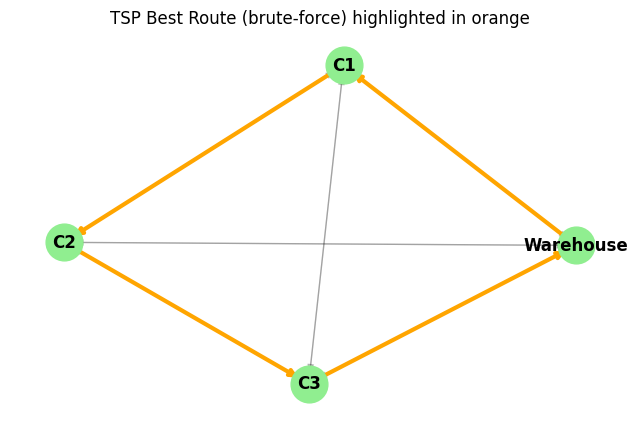

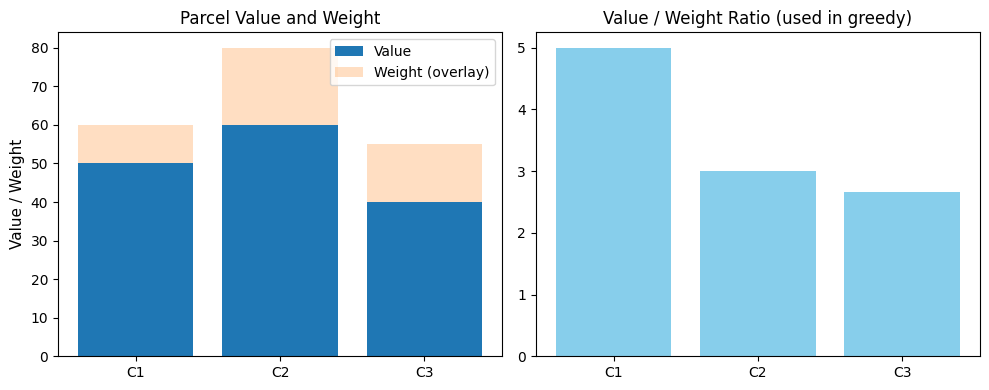

In [10]:

# 1) Visualize chosen TSP best route (from brute-force result)
best_route = bf_route
route_edges = [(best_route[i], best_route[i+1]) for i in range(len(best_route)-1)]
plt.figure(figsize=(8,5))
nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=700)
nx.draw_networkx_labels(G, pos, font_weight='bold')
nx.draw_networkx_edges(G, pos, alpha=0.2)
# highlight route edges
nx.draw_networkx_edges(G, pos, edgelist=route_edges, width=3, edge_color='orange', arrows=True)
plt.title("TSP Best Route (brute-force) highlighted in orange")
plt.axis('off')
plt.show()

# 2) Profit vs Weight bar chart for parcels
loc_names = list(parcels.keys())
values = [parcels[l]['value'] for l in loc_names]
weights = [parcels[l]['weight'] for l in loc_names]
ratios = [v/w for v,w in zip(values, weights)]

x = np.arange(len(loc_names))
fig, ax = plt.subplots(1,2, figsize=(10,4), gridspec_kw={'width_ratios':[1,1]})
ax[0].bar(x, values, label='Value')
ax[0].bar(x, weights, bottom=values, alpha=0.25, label='Weight (overlay)')
ax[0].set_xticks(x); ax[0].set_xticklabels(loc_names)
ax[0].set_ylabel('Value / Weight')
ax[0].set_title('Parcel Value and Weight')
ax[0].legend()

ax[1].bar(x, ratios, color='skyblue')
ax[1].set_xticks(x); ax[1].set_xticklabels(loc_names)
ax[1].set_title('Value / Weight Ratio (used in greedy)')
plt.tight_layout()
plt.show()

# 3) Time-window schedule visualization for greedy selection if feasible
if times:
    fig, ax = plt.subplots(figsize=(8,3))
    y = 1
    for loc, arrival, start_service in times:
        earliest, latest = parcels[loc]['time']
        ax.hlines(y, earliest, latest, colors='grey', linewidth=8, alpha=0.4) # allowed window
        ax.plot(arrival, y, 'o', label='arrival' if y==1 else "")
        ax.plot(start_service, y, 's', label='start' if y==1 else "")
        ax.text(latest+0.05, y, f"{loc}", va='center')
        y -= 0.5
    ax.set_ylim(0.4, 1.6)
    ax.set_xlabel("Time")
    ax.set_yticks([])
    ax.set_title("Time-window feasibility (grey bars = allowed windows)")
    ax.legend()
    plt.show()


In [11]:
print("SUMMARY")
print("-------")
print("Locations:", locations)
print("Vehicle capacity:", vehicle_capacity)
print("Parcels:", parcels)
print("\nGreedy knapsack selected:", greedy_selection)
if feasible:
    print("Feasible order for greedy selection:", order)
    print("Arrival & service times:", times)
print("\nTSP (Brute-force) route:", bf_route, "cost:", bf_cost)
print("TSP (Held-Karp) route:", hk_route, "cost:", hk_cost)

print("\nPackaging instructions for GitHub:")
print(" - README.md (describe strategy + how to run)")
print(" - delivery_route_optimization.ipynb (this notebook)")
print(" - requirements.txt (networkx, matplotlib, numpy)")


SUMMARY
-------
Locations: ['Warehouse', 'C1', 'C2', 'C3']
Vehicle capacity: 30
Parcels: {'C1': {'value': 50, 'time': (9, 12), 'weight': 10}, 'C2': {'value': 60, 'time': (10, 13), 'weight': 20}, 'C3': {'value': 40, 'time': (11, 14), 'weight': 15}}

Greedy knapsack selected: [('C1', 50, 10, (9, 12)), ('C2', 60, 20, (10, 13))]

TSP (Brute-force) route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] cost: 18
TSP (Held-Karp) route: ['Warehouse', 'C3', 'C2', 'C1', 'Warehouse'] cost: 18

Packaging instructions for GitHub:
 - README.md (describe strategy + how to run)
 - delivery_route_optimization.ipynb (this notebook)
 - requirements.txt (networkx, matplotlib, numpy)
